In [100]:
""" 
    Implementation of transcribers for the task
    'Korean Automatic Singing Transcription'
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchinfo import summary

import os
import sys
import easydict
import yaml

import audio_utils
from conformer import ConformerBlock
from tony.tony_network.tony_utils import *
from tony.tony_network.conformer_transcriber import *
from tony.front_end import *

import matplotlib.pyplot as plt

config_dir = '/data1/singing_inpainting/transcription/model/configs.yaml'
with open(config_dir, 'r') as f:
    configs = yaml.load(f)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [77]:
tony_args = easydict.EasyDict({
    "mel_channel_num": 128,
    "using_features": ['mel'],
    "est_target": 'both',
    "num_pitch_label": 88,
    "num_phoneme_label": 46,
    "model_arc": "Conformer",
    "model_options": "small",
    "segment_length": 1024*60,
    "n_fft" : 1024,
    "win_length" : 1024,
    "hop_length" : 256,
    "eps": 1e-7,
    "channel": 'mono',
    "window" : 'hann',
    "sample_rate": 22050,
    "front_end_using_spec": ["log_mel"],
    })
model_arc = tony_args.model_arc
model_options = tony_args.model_options
config = configs[model_arc][model_options]

tony_args.cfg = configs[model_arc][model_options]
config['nums_encoder_layers'] = 4

In [78]:

# Conformer
class jj_Conformer(nn.Module):
    def __init__(self, args, drop_rate=0.1):
        super(jj_Conformer, self).__init__()
        config = args.cfg
        feature_dimension_dict = {'mel':args.mel_channel_num}
        self.using_features = args.using_features
        assert self.using_features, "at least a single using feature for the network input must be given"

        ''' Convolution Subsampling Module '''
        self.conv_subsample_modules = nn.ModuleDict()
        subsample_combined_out_dimension = 0
        for cur_feature in self.using_features:
            cur_out_dim = config["subsample_out_dim"]
            cur_subsample_sequential = nn.Sequential(
                nn.Conv2d(1, cur_out_dim, kernel_size=config["subsample_kernel_size"], stride=config["subsample_stride_size"], padding=config["subsample_padding_size"]),
                nn.ReLU(),
                nn.Conv2d(cur_out_dim, cur_out_dim, kernel_size=config["subsample_kernel_size"], stride=config["subsample_stride_size"], padding=config["subsample_padding_size"]),
                nn.ReLU(),
            )
            self.conv_subsample_modules[cur_feature] = cur_subsample_sequential
            subsample_combined_out_dimension += (cur_out_dim * feature_dimension_dict[cur_feature] // (config["subsample_stride_size"]*2))
        
        # project subsampled outputs to match input of the conformer block
        self.input_projection = nn.Sequential(
			Linear(subsample_combined_out_dimension, config["encoder_dim"]),
			nn.Dropout(p=drop_rate),
		)

        ''' Conformer Encoder and Decoder '''
        # encoder
        self.conformer_blocks = nn.ModuleList()
        for i in range(config["nums_encoder_layers"]):
            self.conformer_blocks.append(ConformerBlock(dim=config["encoder_dim"], dim_head=config["encoder_dim"]//config["num_attention_heads"], \
                                                        heads=config["num_attention_heads"], ff_mult=config["feed_forward_expansion_rate"], \
                                                        conv_expansion_factor=config["conv_expansion_factor"], conv_kernel_size=config["conv_kernel_size"], \
                                                        attn_dropout=config["attention_dropout_rate"], ))

    def forward(self, input_features):

        ''' Convolutional Subsampling '''
        subsample_outputs_combined = []
        for input_index, cur_key in enumerate(self.using_features):
#             assert cur_key in input_features, f"No feature named '{cur_key}' in input\n   check the configuration and solver file"
            # subsample module output shape : batch x channels x dimension x time
#             cur_subsample_output = self.conv_subsample_modules[cur_key](input_features[cur_key].unsqueeze(1))
            
            cur_subsample_output = self.conv_subsample_modules[cur_key](input_features)
            batch_size, channels, dim, lengths = cur_subsample_output.size()
            # reshaped to : batch x dimension x time
            cur_subsample_output = cur_subsample_output.reshape(batch_size, channels*dim, lengths)
            # combine results
            subsample_outputs_combined = cur_subsample_output if input_index==0 \
                                    else torch.cat((subsample_outputs_combined, cur_subsample_output), axis=1)

        outputs = self.input_projection(subsample_outputs_combined.permute(0,2,1))

        ''' Encoding '''
        for cur_enc_layer in self.conformer_blocks:
            outputs = cur_enc_layer(outputs)

In [79]:
network = jj_Conformer(tony_args)
pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f"Number of trainable parameters : {pytorch_total_params}")


Number of trainable parameters : 10171984


In [80]:
tony_model_dir = '/data1/singing_inpainting/transcription/results/conformer_small_mel_only/100/conformer_small_mel_only_transcriber_100.pt'
model_dict = network.state_dict()
tony_model = torch.load(tony_model_dir)
tony_model_dict = tony_model['model']

In [81]:
pretrained_dict = {k.split('module.')[-1]: v for k, v in tony_model_dict.items() if k.split('module.')[-1] in model_dict}
model_dict.update(pretrained_dict)
network.load_state_dict(model_dict)

<All keys matched successfully>

In [82]:
input = {'mel':torch.rand(batch_size, 1, tony_args.mel_channel_num, time_length)}
input['mel'].shape

NameError: name 'batch_size' is not defined

In [83]:
batch_size = 4
time_length = tony_args.segment_length // tony_args.hop_length

input = {'mel':torch.rand(batch_size, 1, tony_args.mel_channel_num, time_length)}
summary(network, input_data=input['mel'], device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
jj_Conformer                                       --                        --
├─ModuleList: 1-1                                  --                        --
├─ModuleDict: 1                                    --                        --
│    └─Sequential: 2-1                             [4, 128, 32, 60]          --
│    │    └─Conv2d: 3-1                            [4, 128, 64, 120]         1,280
│    │    └─ReLU: 3-2                              [4, 128, 64, 120]         --
│    │    └─Conv2d: 3-3                            [4, 128, 32, 60]          147,584
│    │    └─ReLU: 3-4                              [4, 128, 32, 60]          --
├─Sequential: 1-2                                  [4, 60, 144]              --
│    └─Linear: 2-2                                 [4, 60, 144]              --
│    │    └─Linear: 3-5                            [4, 60, 144]              589,968
│    └─Dropout: 2-3   

In [84]:
2, 128, 256, 60
2, 128*256, 60

(2, 32768, 60)

In [85]:
2, 32768, 60
2, 60, 32768

(2, 60, 32768)

In [620]:
128*32

4096

In [627]:
print(pytorch_model_summary.summary(network, torch.zeros(4, 1, 128, 240), show_input=True))

-------------------------------------------------------------------------
        Layer (type)         Input Shape         Param #     Tr. Param #
            Linear-1       [4, 60, 4096]         589,968         589,968
           Dropout-2        [4, 60, 144]               0               0
    ConformerBlock-3        [4, 60, 144]         589,572         589,572
    ConformerBlock-4        [4, 60, 144]         589,572         589,572
    ConformerBlock-5        [4, 60, 144]         589,572         589,572
    ConformerBlock-6        [4, 60, 144]         589,572         589,572
    ConformerBlock-7        [4, 60, 144]         589,572         589,572
    ConformerBlock-8        [4, 60, 144]         589,572         589,572
    ConformerBlock-9        [4, 60, 144]         589,572         589,572
   ConformerBlock-10        [4, 60, 144]         589,572         589,572
   ConformerBlock-11        [4, 60, 144]         589,572         589,572
   ConformerBlock-12        [4, 60, 144]         5

In [86]:
conv_subsample_modules = nn.ModuleDict()
subsample_combined_out_dimension = 0
using_features = tony_args.using_features
feature_dimension_dict = {'mel':tony_args.mel_channel_num}
drop_rate = 0.1

for cur_feature in using_features:
    cur_out_dim = config["subsample_out_dim"]
    cur_subsample_sequential = nn.Sequential(
        nn.Conv2d(1, cur_out_dim, kernel_size=config["subsample_kernel_size"], stride=config["subsample_stride_size"], padding=config["subsample_padding_size"]),
        nn.ReLU(),
        nn.Conv2d(cur_out_dim, cur_out_dim, kernel_size=config["subsample_kernel_size"], stride=config["subsample_stride_size"], padding=config["subsample_padding_size"]),
        nn.ReLU(),
    )
    conv_subsample_modules[cur_feature] = cur_subsample_sequential
    subsample_combined_out_dimension += (cur_out_dim * feature_dimension_dict[cur_feature] // (config["subsample_stride_size"]*2))

input_projection = nn.Sequential(
			Linear(subsample_combined_out_dimension, config["encoder_dim"]),
			nn.Dropout(p=drop_rate),
		)

In [87]:
cur_feature = 'mel'
conv_subsample_modules[cur_feature] = cur_subsample_sequential

In [88]:
cur_key = ['mel'][0]
cur_subsample_output = conv_subsample_modules[cur_key](torch.zeros([4, 128, 240]).unsqueeze(1))
print(cur_subsample_output.shape)
batch_size, channels, dim, lengths = cur_subsample_output.size()
# reshaped to : batch x dimension x time
cur_subsample_output = cur_subsample_output.reshape(batch_size, channels*dim, lengths)
subsample_outputs_combined = cur_subsample_output
subsample_outputs_combined.shape

torch.Size([4, 128, 32, 60])


torch.Size([4, 4096, 60])

In [89]:
outputs = input_projection(subsample_outputs_combined.permute(0,2,1))

In [90]:
60 * 144

8640

In [113]:
audio_dir = '/data1/singing_inpainting/dataset/marg_singing/MargFemale01/린 - 실화_0008.wav'
audio_data, sr = torchaudio.load(audio_dir)
resample = torchaudio.transforms.Resample(orig_freq = sr, new_freq = 22050)
new_audio_data = resample(audio_data)

In [114]:
new_audio_data = new_audio_data.cuda()
front_end = FrontEnd(tony_args)
input_spec, input_phase = front_end(new_audio_data, mode=tony_args.front_end_using_spec)
log_input_spec = torch.log10(input_spec+tony_args.eps)


/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [154]:
linear_to_db = torchaudio.transforms.AmplitudeToDB('power')
complex_spec = audio_utils.get_spectrogram(audio_data, power=None, return_complex=1)
mag_spec = torch.abs(complex_spec)
mag_spec = mag_spec ** 2
db_mag_spec = linear_to_db(mag_spec)
mag_spec = torchaudio.functional.DB_to_amplitude(db_mag_spec, ref=1.0, power=1)
mag_spec[0, -1, :]=0
mel_scale = torchaudio.transforms.MelScale(n_mels = 128, sample_rate = 44100, n_stft=1025, f_min=0, f_max=22050/2)
# mel_scale = torchaudio.transforms.MelScale(n_mels = 128, sample_rate = 44100, n_stft=514)
mel_spec = mel_scale(mag_spec[0])
# mel_spec = mel_scale(mag_spec[0][:514])

# log_mel_spec = linear_to_db(mel_spec)
log_mel_spec = torch.log10(mel_spec)


In [116]:
a = mag_spec.clone().unsqueeze(0)
aa = torch.nn.functional.pad(a, (0, 0, 0, 1), mode='constant', value=0)
a.shape, aa.shape

(torch.Size([1, 1, 1025, 1435]), torch.Size([1, 1, 1026, 1435]))

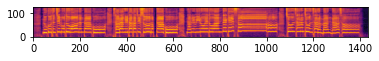

In [117]:
plt.imshow(input_spec[0].cpu(), origin='lower', cmap='inferno')

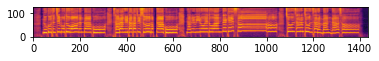

In [118]:
plt.imshow(log_mel_spec, origin='lower', cmap='inferno')

In [119]:
index_matrix[mask_start]

IndexError: index 10 is out of bounds for dimension 0 with size 4

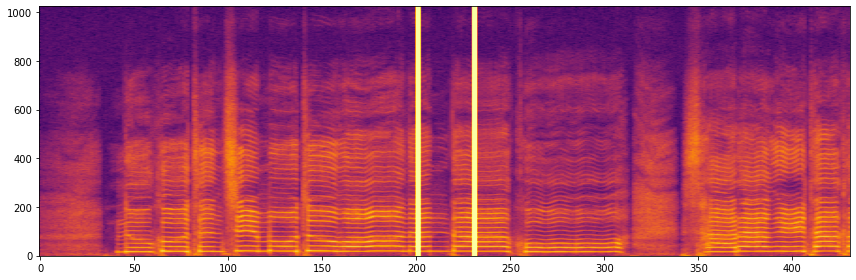

In [172]:
fig, axes = plt.subplots(1,1)
axes.imshow(db_mag_spec[0][:,:431], aspect='auto', origin='ower', cmap='inferno')
fig.set_size_inches(12, 4)
fig.tight_layout()
plt.savefig('test.png')

In [138]:
db_mag_spec.min(), db_mag_spec.max()

(tensor(-100.), tensor(45.4323))

In [155]:
db_mag_spec2 = db_mag_spec

In [156]:
db_mag_spec2[0][:,200:203] = 50
db_mag_spec2[0][:,230:233] = 50

NameError: name 'mel_scaledb_mag_spec2' is not defined

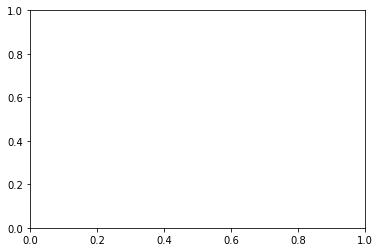

In [171]:
fig, axes = plt.subplots(1,1)
axes.imshow(mel_scaledb_mag_spec2[0][:,:431], aspect='auto', origin='ower', cmap='inferno')
fig.set_size_inches(12, 4)
fig.tight_layout()
plt.savefig('test.png')

In [46]:
db_mag_spec2[0][:,80:80+273]

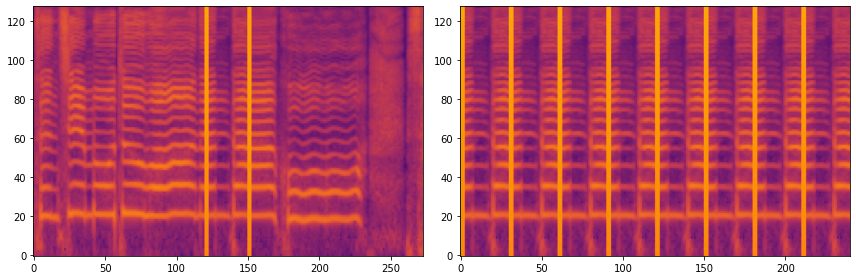

In [170]:
fig, axes = plt.subplots(1,2)
a = db_mag_spec2[0][:,80:80+273]
a = torchaudio.functional.DB_to_amplitude(a, ref=1.0, power=1)
b = torchaudio.functional.DB_to_amplitude(t, ref=1.0, power=1)
axes[0].imshow(mel_scale(a).log10(), aspect='auto', origin='ower', cmap='inferno', vmin=-10, vmax=10)
axes[1].imshow(mel_scale(b).log10(), aspect='auto', origin='ower', cmap='inferno', vmin=-10, vmax=10)

fig.set_size_inches(12, 4)
fig.tight_layout()
plt.savefig('test.png')

In [169]:
mel_scale(a).log10().min(),mel_scale(a).log10().max(),

(tensor(-5.4215), tensor(6.0657))

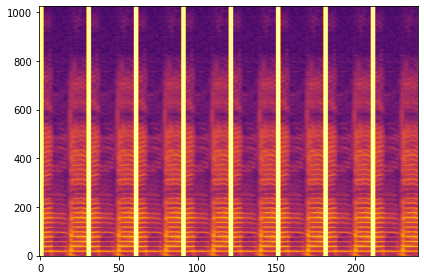

In [160]:
t = db_mag_spec2[0][:,200:230].repeat(1, 8)
fig, axes = plt.subplots(1,1)
axes.imshow(t, aspect='auto', origin='ower', cmap='inferno')
fig.set_size_inches(6, 4)
fig.tight_layout()
plt.savefig('test.png')

In [52]:
repeat_num = torch.ceil(mel_length / mask_region_length[1])

In [51]:
mask_region_length

tensor([ 2, 11, 81, 81])

In [53]:
repeat_num

tensor(25.)

In [57]:
273 / 11

24.818181818181817

In [55]:
mask_region_length[1]

tensor(11)

In [56]:
mel_length

tensor(273)

In [73]:
mel_spec_22050 = torch.zeros(fake_data.shape[0], fake_data.shape[1], fake_data.shape[2], mel_length)
for i in range(fake_data.shape[0]):
    repeat_num = torch.ceil(mel_length / mask_region_length[i])
    mask_region = fake_data[i,:,:,mask_start[i]:mask_end[i]]
    repeated = mask_region.repeat(1, 1, 1, repeat_num.int())
    repeated = torch.nn.functional.pad(repeated, (0, torch.max(torch.tensor(0), mel_length - repeated.shape[-1])), mode='constant', value=0)
    repeated = repeated[:,:,:,:mel_length]
    mel_spec_22050[i] = repeated

In [74]:
mel_spec_22050

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
    

In [40]:
fake_data.sum(axis=2).shape == 

torch.Size([4, 1, 428])